In [2]:
import pandas as pd
import sqlite3
import sqlalchemy as db
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import seaborn as sns

%matplotlib inline

In [3]:
# Data from http://web.mta.info/developers/turnstile.html

def get_data(weeks):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    
    for week in weeks:
        week_url = url.format(week)
        dfs.append(pd.read_csv(week_url, parse_dates = [['DATE','TIME']], keep_date_col=True))
    return pd.concat(dfs)

weeks = [210925, 210918, 210911, 210904, 210828, 210821, 210814, 210807, 210731, 210724, 210717, 210710, 210703]

mta_data = get_data(weeks)   

In [3]:
#trying with sqlalchemy
engine = db.create_engine('sqlite:///mta_data.db')
df = pd.read_sql('select * from mta_data limit 1;', engine)

# trying with sqlite3 (not working)
#conn = sqlite3.connect('sqlite:////mta_data.db')
#cursor = conn.cursor()

In [4]:
#mta_data.info()
engine.table_names()

/tmp/ipykernel_12903/18776725.py:2: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  engine.table_names()


['mta_data']

In [49]:
mta_data_from_sql = pd.read_sql('SELECT COUNT(*) FROM mta_data;', engine)

mta_data_from_sql

,COUNT(*)
0,2724418


In [1]:
#poverty_data = pd.read_csv('child_poverty_nyc/Child Poverty.csv')
#poverty_data.head()

mta_data

NameError: name 'mta_data' is not defined

In [7]:
mta_data.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)

In [8]:
mta_data.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [9]:
turnstiles_daily = mta_data.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"],as_index=False).ENTRIES.first() 

In [10]:
#turnstiles_daily.head()

In [11]:
turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE_TIME", "ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))

/tmp/ipykernel_12903/371803254.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily


In [12]:
#turnstiles_daily.head()

In [13]:
turnstiles_daily[turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"]].head()

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES,PREV_DATE,PREV_ENTRIES
21299,A011,R080,01-03-00,57 ST-7 AV,2021-06-26 04:00:00,885595259,2021-06-26 00:00:00,885595278.0
21300,A011,R080,01-03-00,57 ST-7 AV,2021-06-26 08:00:00,885595248,2021-06-26 04:00:00,885595259.0
21301,A011,R080,01-03-00,57 ST-7 AV,2021-06-26 12:00:00,885595226,2021-06-26 08:00:00,885595248.0
21302,A011,R080,01-03-00,57 ST-7 AV,2021-06-26 16:00:00,885595182,2021-06-26 12:00:00,885595226.0
21303,A011,R080,01-03-00,57 ST-7 AV,2021-06-26 20:00:00,885595097,2021-06-26 16:00:00,885595182.0


In [14]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=1000000)

193 8049630.0
167790067 702272.0
151 5610355.0
35 9769328.0
33565227 188201.0
31 8724126.0
66 3272795.0
67 1605140.0
5671 4298891.0
0 117440512.0
15848006 2216515.0
2216520 15848006.0
10487784 2024.0
2024 10487784.0
327680 7577112.0
67109632 14.0
327682 67109640.0
15 67109632.0
14 1198448.0
46 5405537.0
23 705357551.0
16777220 1037161.0
6 16034831.0
34 6214051.0
37 1950780.0
173 15689534.0
8 1255797.0
11123659 4624026.0
5 11123659.0
1891101745 1104755.0
43 3154069.0
56 3102579.0
19 2570919.0
50362839 251769.0
114 1953573.0
90 4788322.0
26 6250045.0
67 1040931990.0
118 909043641.0
196713 1891026.0
11 3145979.0
94 3530461.0
5 1309264042.0
1309264152 5.0
35 10737302.0
201331802 798740.0
25 5768873.0
1089962288 146746691.0
3538954 51735380.0
0 2030205.0
37 7682472.0
1189019447 3740789.0
346167 14045092.0
14049774 346213.0
774447 9475375.0
9480674 774522.0
7979566 789214.0
794786 7979671.0
1278449 8197329.0
8204122 1278639.0
635 4005927.0
4006679 635.0
8 1684120.0
327681 50346231.0
23 64814

In [15]:
#turnstiles_daily.head()

In [16]:
station_daily = turnstiles_daily.groupby(["STATION", "DATE_TIME"])[['DAILY_ENTRIES']].sum().reset_index()
station_daily.head(100)

,STATION,DATE_TIME,DAILY_ENTRIES
0,1 AV,2021-06-26 00:00:00,0.0
1,1 AV,2021-06-26 04:00:00,741.0
2,1 AV,2021-06-26 08:00:00,240.0
3,1 AV,2021-06-26 12:00:00,975.0
4,1 AV,2021-06-26 16:00:00,1957.0
...,...,...,...
95,1 AV,2021-07-11 16:00:00,1506.0
96,1 AV,2021-07-11 20:00:00,1559.0
97,1 AV,2021-07-12 00:00:00,1067.0
98,1 AV,2021-07-12 04:00:00,142.0


In [17]:
busy_stations = station_daily.groupby(['STATION'])[['DAILY_ENTRIES']].max()

In [18]:
#busy_stations.info()

In [19]:
#busy_stations.sort_values(by=['DAILY_ENTRIES'], inplace=True, ascending=False)

In [20]:
#busy_stations.head(40)

In [21]:
#busy_stations.tail()

In [22]:
stations_geo = pd.read_csv('DOITT_SUBWAY_STATION_01_13SEPT2010.csv')

In [23]:
stations_geo.drop(['URL','OBJECTID'], axis=1, inplace=True)

In [24]:
stations_geo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473 entries, 0 to 472
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   NAME      473 non-null    object
 1   the_geom  473 non-null    object
 2   LINE      473 non-null    object
 3   NOTES     473 non-null    object
dtypes: object(4)
memory usage: 14.9+ KB


In [25]:
stations_geo.rename(columns={'NAME':'STATION'}, inplace=True)

In [26]:
stations_geo['STATION'] = stations_geo['STATION'].str.upper()

In [27]:
#stations_geo.head(40)

In [28]:
busy_stations_geo = pd.merge(busy_stations, stations_geo, on='STATION', how='inner')
#is inner join correct??

In [29]:
busy_stations_geo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110 entries, 0 to 109
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   STATION        110 non-null    object 
 1   DAILY_ENTRIES  110 non-null    float64
 2   the_geom       110 non-null    object 
 3   LINE           110 non-null    object 
 4   NOTES          110 non-null    object 
dtypes: float64(1), object(4)
memory usage: 5.2+ KB


In [30]:
busy_stations_geo.the_geom = busy_stations_geo.the_geom.str.strip('POINT ')

In [31]:
#busy_stations_geo.head()

In [32]:
busy_stations_geo[['LONG','LAT']] = busy_stations_geo.the_geom.str.split(' ', expand=True)

In [33]:
busy_stations_geo.LONG = busy_stations_geo.LONG.str.strip('(')
busy_stations_geo.LONG = busy_stations_geo.LONG.astype(float)

In [34]:
busy_stations_geo.LAT = busy_stations_geo.LAT.str.strip(')')
busy_stations_geo.LAT = busy_stations_geo.LAT.astype(float)

In [35]:
busy_stations_geo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110 entries, 0 to 109
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   STATION        110 non-null    object 
 1   DAILY_ENTRIES  110 non-null    float64
 2   the_geom       110 non-null    object 
 3   LINE           110 non-null    object 
 4   NOTES          110 non-null    object 
 5   LONG           110 non-null    float64
 6   LAT            110 non-null    float64
dtypes: float64(3), object(4)
memory usage: 6.9+ KB


In [36]:
###sanity check that busy_stations_geo is counting the same number of stations there actually are
len(mta_data.STATION.unique())

379

In [37]:
boroughs = gpd.read_file('borough_shapes/geo_export_d86d1c64-637c-4b79-9310-4aa2d5aeefdb.shp')
#fig, ax = plt.subplots(figsize=(15,15))
#boroughs.plot(ax=ax)
crs = {'init':'epsg:4326'}

In [38]:
geometry = [Point(xy) for xy in zip(busy_stations_geo['LONG'], busy_stations_geo['LAT'])]
geometry[:3]

geo_stations = gpd.GeoDataFrame(busy_stations_geo, crs=crs, geometry=geometry)
geo_stations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 110 entries, 0 to 109
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   STATION        110 non-null    object  
 1   DAILY_ENTRIES  110 non-null    float64 
 2   the_geom       110 non-null    object  
 3   LINE           110 non-null    object  
 4   NOTES          110 non-null    object  
 5   LONG           110 non-null    float64 
 6   LAT            110 non-null    float64 
 7   geometry       110 non-null    geometry
dtypes: float64(3), geometry(1), object(4)
memory usage: 7.7+ KB


/home/mattiboi/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<AxesSubplot:>

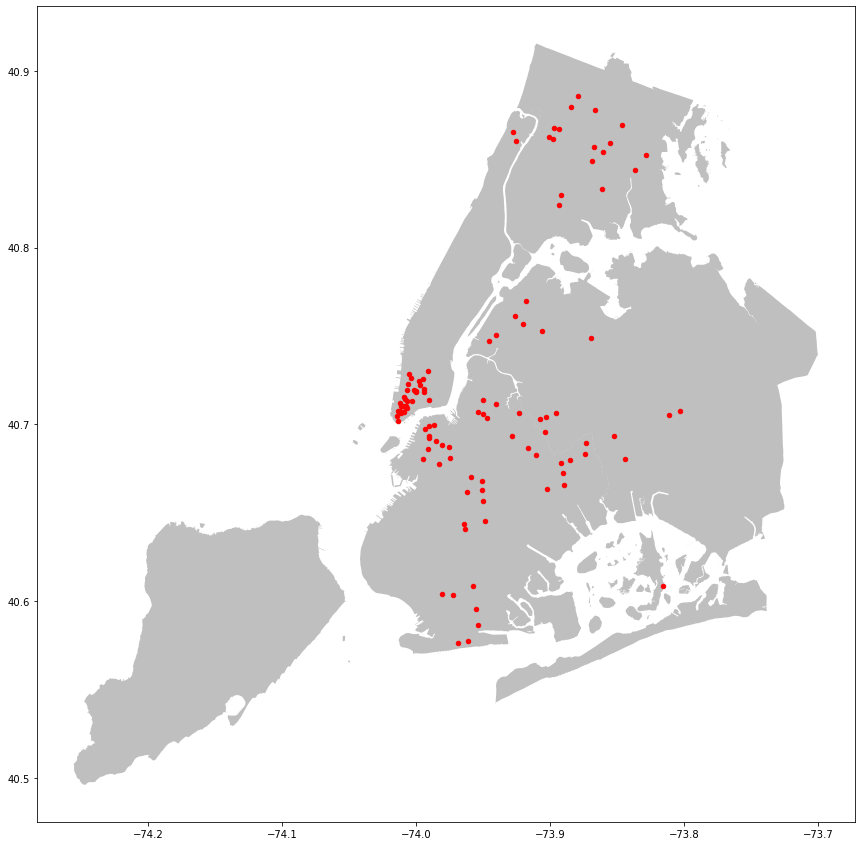

In [39]:
fig, ax = plt.subplots(figsize=(15,15))
boroughs.plot(ax=ax, alpha=0.5, color='grey')
geo_stations['geometry'].plot(ax=ax, markersize=20, color='red')

In [40]:
geo_stations.sort_values(by=['DAILY_ENTRIES'], inplace=True, ascending=False)

In [41]:
geo_stations.head(20)

,STATION,DAILY_ENTRIES,the_geom,LINE,NOTES,LONG,LAT,geometry
62,JUNCTION BLVD,2308387.0,(-73.86952700103515 40.74914499948836),7-7 Express,"7-all times, 7 Express-rush hours AM westbound...",-73.869527,40.749145,POINT (-73.86953 40.74914)
59,HOUSTON ST,995180.0,(-74.00536700180581 40.728251000730204),1-2,"1-all times, 2-nights",-74.005367,40.728251,POINT (-74.00537 40.72825)
82,PELHAM PKWY,799286.0,(-73.86748067850041 40.8571924091606),2-5,"2-all times, 5-rush hours AM southbound, PM no...",-73.867481,40.857192,POINT (-73.86748 40.85719)
83,PELHAM PKWY,799286.0,(-73.85535900043564 40.858984999820116),5,5-all times,-73.855359,40.858985,POINT (-73.85536 40.85898)
47,FULTON ST,501987.0,(-74.00762309323994 40.71016216530185),A-C,"A-all times, C-all times exc nights",-74.007623,40.710162,POINT (-74.00762 40.71016)
48,FULTON ST,501987.0,(-74.00657099970202 40.70941599925865),2-3,"2-all times, 3-all times exc nights",-74.006571,40.709416,POINT (-74.00657 40.70942)
49,FULTON ST,501987.0,(-74.00793800110387 40.71002266658424),J-Z,"J-all times, Z-rush hours AM westbound, PM eas...",-74.007938,40.710023,POINT (-74.00794 40.71002)
50,FULTON ST,501987.0,(-74.00950899856461 40.710367998822136),4-5,"4-all times, 5-weekdays",-74.009509,40.710368,POINT (-74.00951 40.71037)
46,FULTON ST,501987.0,(-73.97537499833149 40.68711899950771),G,G-all times,-73.975375,40.687119,POINT (-73.97537 40.68712)
1,ASTORIA BLVD,263279.0,(-73.91809500109238 40.77003699949086),N-W,"N-all times, W part time",-73.918095,40.770037,POINT (-73.91810 40.77004)


In [42]:
geo_stations.drop_duplicates(subset='DAILY_ENTRIES', keep='first', inplace=True)

In [43]:
survey_list = geo_stations[:20]

In [50]:
survey_list.head(20)
#survey_list.to_csv("stations_to_survey.csv")

,STATION,DAILY_ENTRIES,the_geom,LINE,NOTES,LONG,LAT,geometry
62,JUNCTION BLVD,2308387.0,(-73.86952700103515 40.74914499948836),7-7 Express,"7-all times, 7 Express-rush hours AM westbound...",-73.869527,40.749145,POINT (-73.86953 40.74914)
59,HOUSTON ST,995180.0,(-74.00536700180581 40.728251000730204),1-2,"1-all times, 2-nights",-74.005367,40.728251,POINT (-74.00537 40.72825)
82,PELHAM PKWY,799286.0,(-73.86748067850041 40.8571924091606),2-5,"2-all times, 5-rush hours AM southbound, PM no...",-73.867481,40.857192,POINT (-73.86748 40.85719)
47,FULTON ST,501987.0,(-74.00762309323994 40.71016216530185),A-C,"A-all times, C-all times exc nights",-74.007623,40.710162,POINT (-74.00762 40.71016)
1,ASTORIA BLVD,263279.0,(-73.91809500109238 40.77003699949086),N-W,"N-all times, W part time",-73.918095,40.770037,POINT (-73.91810 40.77004)
53,GUN HILL RD,262499.0,(-73.86613410538703 40.877839385172024),2-5,"2-all times, 5-rush hours AM southbound, PM no...",-73.866134,40.877839,POINT (-73.86613 40.87784)
104,WALL ST,251799.0,(-74.01186199860112 40.70755700086603),4-5,"4-all times, 5-weekdays",-74.011862,40.707557,POINT (-74.01186 40.70756)
14,BROAD ST,150231.0,(-74.01105599991755 40.706476001106005),J-Z,"J-all times, Z-rush hours AM westbound, PM eas...",-74.011056,40.706476,POINT (-74.01106 40.70648)
22,CANAL ST,125355.0,(-74.00105471306033 40.718814263587134),N-Q,"N-all times, Q-weekdays and evenings",-74.001055,40.718814,POINT (-74.00105 40.71881)
70,LORIMER ST,107242.0,(-73.95024799996972 40.71407200064717),L,L-all times,-73.950248,40.714072,POINT (-73.95025 40.71407)


In [45]:
#busy_stations_geo.info()

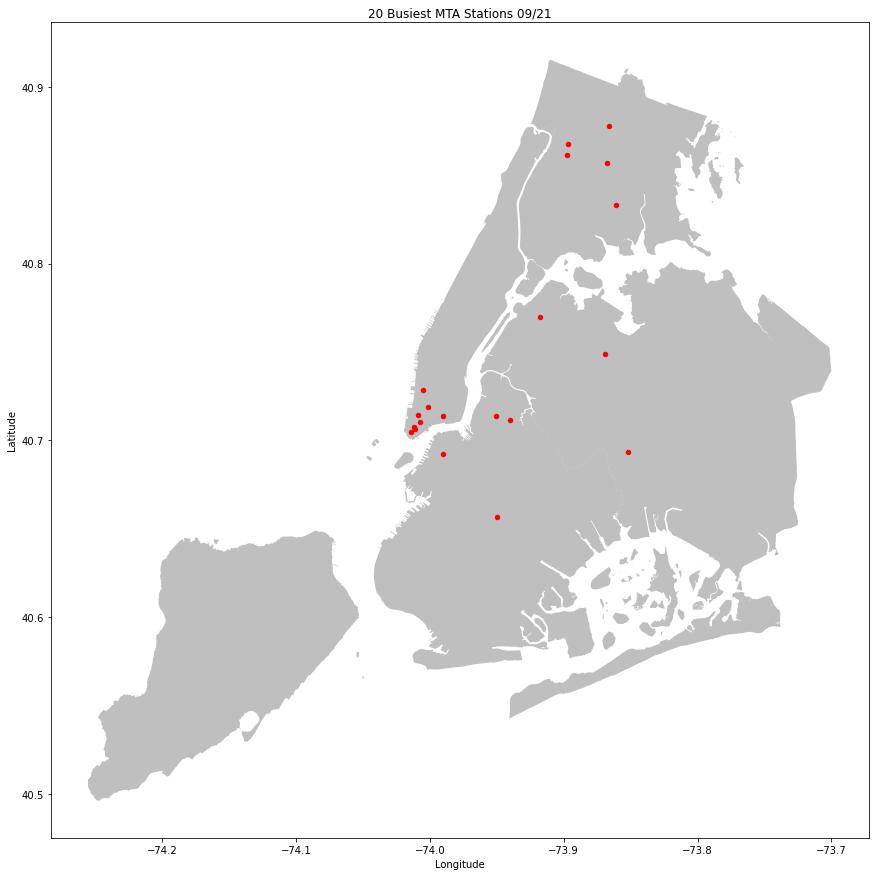

In [46]:
fig, ax = plt.subplots(figsize=(15,15))
boroughs.plot(ax=ax, alpha=0.5, color='grey')
survey_list['geometry'].plot(ax=ax, markersize=20, color='red')
plt.title('20 Busiest MTA Stations 09/21')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('mvp_map')

Checking In With Lisa:

- How to proceed with showing traffic at the stations in my survey list? (busiest times, daily totals, ...)

- How to determine which times each station on the survey list is busiest? Is it possible to mask with my survey list?

- I am looking at entries - how do I indicate this?

In [51]:
survey_stations = list(survey_list['STATION'])

In [52]:
survey_stations

['JUNCTION BLVD',
 'HOUSTON ST',
 'PELHAM PKWY',
 'FULTON ST',
 'ASTORIA BLVD',
 'GUN HILL RD',
 'WALL ST',
 'BROAD ST',
 'CANAL ST',
 'LORIMER ST',
 'FORDHAM RD',
 'WOODHAVEN BLVD',
 'CHAMBERS ST',
 'EAST BROADWAY',
 'GRAND ST',
 'BOROUGH HALL',
 'WINTHROP ST',
 'PARKCHESTER',
 'BOWLING GREEN',
 'KINGSBRIDGE RD']

In [57]:
station_daily.head(20)

,STATION,DATE_TIME,DAILY_ENTRIES
0,1 AV,2021-06-26 00:00:00,0.0
1,1 AV,2021-06-26 04:00:00,741.0
2,1 AV,2021-06-26 08:00:00,240.0
3,1 AV,2021-06-26 12:00:00,975.0
4,1 AV,2021-06-26 16:00:00,1957.0
5,1 AV,2021-06-26 20:00:00,2024.0
6,1 AV,2021-06-27 00:00:00,1696.0
7,1 AV,2021-06-27 04:00:00,676.0
8,1 AV,2021-06-27 08:00:00,194.0
9,1 AV,2021-06-27 12:00:00,781.0


In [62]:
survey_stations_daily_datetime = station_daily[station_daily['STATION'].isin(survey_stations)]

I broke this cell somehow.

In [91]:
survey_stations_daily_datetime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14187 entries, 83383 to 384156
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   STATION            14187 non-null  object        
 1   DATE_TIME          14187 non-null  datetime64[ns]
 2   DAILY_ENTRIES      14187 non-null  float64       
 3   AVG_DAILY_ENTRIES  0 non-null      float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 1.0+ MB


In [64]:
def get_data_nodatetime(weeks):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    
    for week in weeks:
        week_url = url.format(week)
        dfs.append(pd.read_csv(week_url, keep_date_col=True))
    return pd.concat(dfs)

mta_data_no_datetime = get_data_nodatetime(weeks)

In [66]:
mta_data_no_datetime.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE", "TIME"], 
                          inplace=True, ascending=False)

In [67]:
mta_data_no_datetime.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE", "TIME"], inplace=True)

In [68]:
daily_turnstiles_no_datetime = mta_data_no_datetime.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE", "TIME"],as_index=False).ENTRIES.first() 

In [87]:
daily_turnstiles_no_datetime.head(20)

,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,06/26/2021,00:00:00,7592792
1,A002,R051,02-00-00,59 ST,06/26/2021,04:00:00,7592804
2,A002,R051,02-00-00,59 ST,06/26/2021,08:00:00,7592816
3,A002,R051,02-00-00,59 ST,06/26/2021,12:00:00,7592870
4,A002,R051,02-00-00,59 ST,06/26/2021,16:00:00,7592992
5,A002,R051,02-00-00,59 ST,06/26/2021,20:00:00,7593116
6,A002,R051,02-00-00,59 ST,06/27/2021,00:00:00,7593175
7,A002,R051,02-00-00,59 ST,06/27/2021,04:00:00,7593182
8,A002,R051,02-00-00,59 ST,06/27/2021,08:00:00,7593188
9,A002,R051,02-00-00,59 ST,06/27/2021,12:00:00,7593227


In [89]:
avg_daily_entries = survey_stations_daily_datetime.groupby(['STATION'])['DAILY_ENTRIES'].mean()

In [90]:
avg_daily_entries

STATION
ASTORIA BLVD       1556.105647
BOROUGH HALL       1408.871841
BOWLING GREEN      1175.009158
BROAD ST            559.478976
CANAL ST           1856.854678
CHAMBERS ST        2169.169369
EAST BROADWAY       839.213628
FORDHAM RD         1548.438628
FULTON ST          2350.662417
GRAND ST           1910.356490
GUN HILL RD         617.000000
HOUSTON ST         2348.342960
JUNCTION BLVD     10510.466292
KINGSBRIDGE RD      972.273205
LORIMER ST          721.932234
PARKCHESTER         894.937729
PELHAM PKWY        2191.827839
WALL ST             920.601826
WINTHROP ST         461.616088
WOODHAVEN BLVD      849.647873
Name: DAILY_ENTRIES, dtype: float64

In [ ]:
sns.line